## Load Data, Get Representation, Train Binary Classification RNN Model
(Binary classification on log fold change)

In [38]:
%load_ext autoreload
%autoreload 2

# %pip install torch
# %pip install fair-esm

import esm
import torch
import json
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# These bind both cellulose & chitin
# These are CBM1s: https://www.uniprot.org/uniprotkb?facets=reviewed%3Atrue&query=(xref%3Aprosite-PS51164) 
cbm1s = {
    'A0A6G0WFR4': 'PGVQIYSQCGGLNYKGPTECQDGLVCIHMSDDFDQCL',
    'O14405': 'PTQTLYGQCGGSGYSGPTRCAPPATCSTLNPYYAQCL',
    'Q9HE18': 'CTAAHWAQCGGIGYSGCTACASPYTCQKANDYYSQCL',
    'Q8WZJ4': 'GVAAHWGQCGGQGWTGPTTCASGTTCTVVNPYYSQCL',
    'P07982': 'QQTVWGQCGGIGWSGPTNCAPGSACSTLNPYYAQCI',
    'Q8NJP6': 'GVAAHWGQCGGSGWTGPTVCESGYTCTYSNAWYSQCL',
    'A0A024SH76': 'ACSSVWGQCGGQNWSGPTCCASGSTCVYSNDYYSQCL',
    'Q9P8P3': 'ATQTHYGQCGGTGWTGPTRCASGYTCQVLNPFYSQCL',
    'A0A0A7EQR3': 'ASAPQWGQCGGIGWTGPTACPSGWACQQLNAYYSQCL',
    'Q8J0K5': 'TGAAQWGQCGGIGWTGPTTCVAPYTCKYENAYYSQCQ',
    'A0A2J8C362': 'SCAALYGQCGGQGWNGATCCSQGTCRASNQWYSQCL',
    'P07981': 'CTQTHWGQCGGIGYSGCKTCTSGTTCQYSNDYYSQCL',
    'G0RV93': 'QSPVWGQCGGIGWSGPTTCVGGATCVSYNPYYSQCI',
    'Q99034': 'PTQTHWGQCGGQGWTGPTQCESGTTCQVISQWYSQCL',
    'Q99036': 'SCSPLYGQCGGSGYTGPTCCAQGTCIYSNYWYSQCL',
    'Q9C1S9': 'CGGIGFNGPTCCQSGSTCVKQNDWYSQC',
    'P07987': 'ACSSVWGQCGGQNWSGPTCCASGSTCVYSNDYYSQCL',
    'P62694': 'PTQSHYGQCGGIGYSGPTVCASGTTCQVLNPYYSQCL',
    'P0CT87': 'QAQEWGQCGGIGWTGATTCVSGTVCTVLNPYYSQCL',
    'A0A1D8EJG8': 'QSGPWQQCGGIGWQGPFTCVSGHTCQVLNDWYHQCV',
    'A0A024SH20': 'QQTVWGQCGGIGWSGPTNCAPGSACSTLNPYYAQCI',
    'Q66NB7': 'QQQQWGQCGGIGWTGATTCVAGSVCSVLNPYYSQCI',
    'Q96WQ9': 'GVAKQYERCGGINHTGPTTCESGSVCKKWNPYYYQCV',
    'Q92400': 'PAQTMWGQCGGQGWTGPTACQSPSTCHVINDFYSQCF',
    'P62695': 'PTQSHYGQCGGIGYSGPTVCASGTTCQVLNPYYSQCL',
    'P79046': 'PEQTRWGQCGGIGWNGPTKCQSPWTCTRLNDWYFQCL',
    'B0Y8K2': 'GVAQHYGQCGGIGWTGPTTCASPYTCQKLNDYYSQCL',
    'O59843': 'NVAQLYGQCGGQGWTGPTTCASGTCTKQNDYYSQCL',
    'Q4U4T0': 'GTVPQWGQCGGEGYSGPTQCVPPYQCVKQGDWWSSCR',
    'A0A024SNB7': 'CTQTHWGQCGGIGYSGCKTCTSGTTCQYSNDYYSQCL',
    'P19355': 'PTQTHYGQCGGIGYSGPTVCASGSTCQVLNPYYSQCL',
    'Q02290': 'NCAAKWGQCGGNGFNGPTCCQNGSRCQFVNEWYSQCL',
    'Q2U2I3': 'QAGPWAQCGGKSFSGSSECASGWKCQELNEWFSQCV',
    'Q8NJ73': 'WGQCGGQGWTGAKTCVSGAVCQAQNEWYSQCV',
    'Q12714': 'CTQTHWGQCGGIGYTGCKTCTSGTTCQYGNDYYSQCL',
    'A0A024RXP8': 'PTQSHYGQCGGIGYSGPTVCASGTTCQVLNPYYSQCL',
    'B7SIW2': 'QSPEWGQCGGIGWTGPTTCVAGTTCVESNPYYSQCL',
    'P15828': 'PKAGRWQQCGGIGFTGPTQCEEPYICTKLNDWYSQCL',
    'Q5ZNB1': 'SGAAHWGQCGGIGWSGPTICVSPYTCQVLNPYYSQCL',
    'A8TGA1': 'NCAAIWGQCGGSGYNGPKCCKQGSCKQINQWYSQCQ',
    'B7SIW1': 'TCSALYGQCGGQGWTGPTCCSSGTCKFSNNWYSQCL',
    'B8M9H9': 'CTAAHWDQCGGNGYTGCTSCASPYTCQKVNDYYSQCL',
    'G2Q9T3': 'DVQTKYGQCGGNGWTGPTVCAPGSSCSVLNEWYSQCL',
    'Q9UVS8': 'SAAQAYGQCGGQGWTGPTTCVSGYTCTYENAYYSQCL',
    'A8PB24': 'VPMYGQCGGSGYTGPTQCDPGLVCVKLNDWYSQCQ',
}

peptides_of_interest =list(set(cbm1s.values()))

In [40]:
len(peptides_of_interest)

40

In [41]:
BATCH_SIZE = 10
OUTPUT_CSV_FILE = "esm2_output.csv"
# Delete the old csv file if you change any of the peptide list
if os.path.exists(OUTPUT_CSV_FILE):
    os.remove(OUTPUT_CSV_FILE)

In [42]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
# model.cuda() # comment this back in if you have access to GPU
model.eval()  # disables dropout for deterministic results

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

# Get the *average* ESM2 embeddings across residues, so hopefully this is agnostic to motif sliding.
In my experience (and in one of my labmate's experiences) just plain averaging ESM2 embeddings works well! 

In [43]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i : i + n]


def call_esm_model(data_chunk):
    # torch.cuda.empty_cache() # Comment back in if you have GPU
    batch_labels, _batch_strs, batch_tokens = batch_converter(data_chunk)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU)
    # batch_tokens.cuda() # If you have GPU you'll need to send tokens to cuda
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    aa_reps = results["representations"][33].detach().cpu().numpy()
    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    mean_reps = []
    for i, tokens_len in enumerate(batch_lens):
        mean_reps.append(aa_reps[i, 1 : tokens_len - 1].mean(0))
    return batch_labels, mean_reps, aa_reps


## Call the ESM2 model on batches of the peptides

NOTE: I wrote this to be robust to network outage or computer shutting down.
If the program stops half way, just hit this cell again and it'll start right back where it left off, no wasted computation

In [44]:
import pdb
seq_col_name = "Sequence"
rep_col_name = "ESM2 Representation"

if os.path.exists(OUTPUT_CSV_FILE):
    df = pd.read_csv(OUTPUT_CSV_FILE, index_col=0)
else:
    df = pd.DataFrame(peptides_of_interest, columns=[seq_col_name])
    df.set_index(seq_col_name, inplace=True)
    df[rep_col_name] = np.nan

esm2_input, mean_reps = None, None
for chunk in tqdm(
    chunks(df, BATCH_SIZE),
    total=np.ceil(len(peptides_of_interest) / BATCH_SIZE),
):
    if not (chunk[rep_col_name].isnull().values.any()):
        # Skip rows which we already know the ESM2 representations for
        continue
    esm2_input = [(seq, seq) for seq in chunk.index.to_numpy()]
    batch_labels, mean_reps, _aa_reps = call_esm_model(esm2_input)

    mask = df.index.isin(batch_labels) & df.columns.isin([rep_col_name])
    df.loc[mask, rep_col_name] = [
        json.dumps([a.item() for a in mean_rep]) for mean_rep in mean_reps
    ]
    df.to_csv(OUTPUT_CSV_FILE)


100%|██████████| 4/4.0 [00:05<00:00,  1.31s/it]


## Read the .csv file of ESM2 representations & load the float arrays from JSON like so:

In [45]:
df = pd.read_csv(OUTPUT_CSV_FILE, index_col=0)
df[rep_col_name] = df[rep_col_name].apply(lambda x: np.array(json.loads(x)))
df[rep_col_name].to_numpy()
df[rep_col_name][0].shape


(1280,)

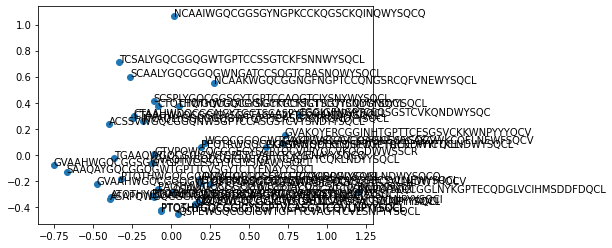

In [46]:
labels = df.index
data = np.vstack( df[rep_col_name])
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

fig, ax = plt.subplots()
ax.scatter(pca_data[:, 0], pca_data[:, 1])

for i, label in enumerate(labels):
    ax.annotate(label, (pca_data[i, 0], pca_data[i, 1]))

plt.show()


A little hard to make sense of, I will note that it seems this embedding is sensitive to the length of peptides...